In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import scipy.signal as sig
from loading import *
from helpers import *
from features import *
from visualization import *

## Loading example signal

In [3]:
data_path = "../data/"
patient_data = load_patient_seizures(data_path, 1,all_seizures=True, delta=1)

In [4]:
eegs = patient_data['eegs']
ranges = patient_data['ranges']
seizure_start_s = patient_data["infos"]["seizure_start"]
seizure_end_s = patient_data["infos"]["seizure_end"] 

In [5]:
num_sensors = len(eegs[0][0])
ordered_power_eeg = top_signals(eegs, ranges, top=num_sensors, id_seizure = None)
max_power_eeg = ordered_power_eeg[0]
min_power_eeg = ordered_power_eeg[-1]

In [6]:
signal = eegs[0][1][max_power_eeg].T

In [7]:
window_size = 128
step_size = 64
indexes = convert_sample_ranges_to_window_ranges(ranges,window_size,step_size,1843200)

## Min

In [8]:
def calculate_min(signal):
    return np.min(signal)

In [9]:
min_feature = calculate_feature(eegs, window_size, step_size, calculate_min, max_power_eeg)
min_feature_example = min_feature[0][1]
scaled_min_feature = scale_signal(min_feature_example, window_size, step_size)

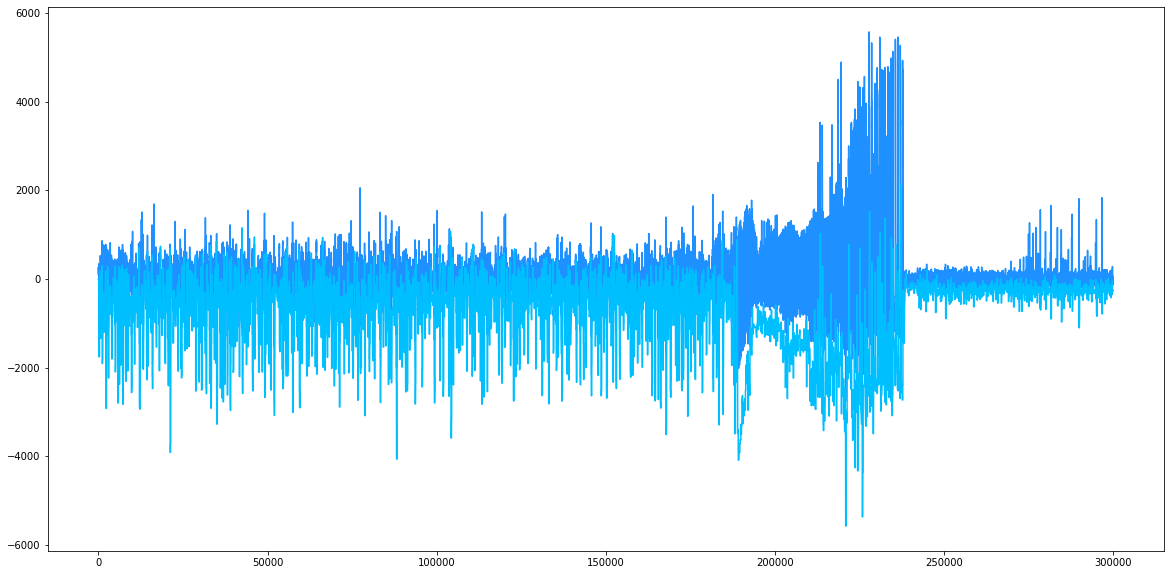

In [10]:
plot_feature(signal, scaled_min_feature, 0, 300000)

## Max

In [11]:
def calculate_max(signal):
    return np.max(signal)

In [12]:
max_feature = calculate_feature(eegs, window_size, step_size, calculate_max, max_power_eeg)
max_feature_example = max_feature[0][1]
scaled_max_feature = scale_signal(max_feature_example, window_size, step_size)

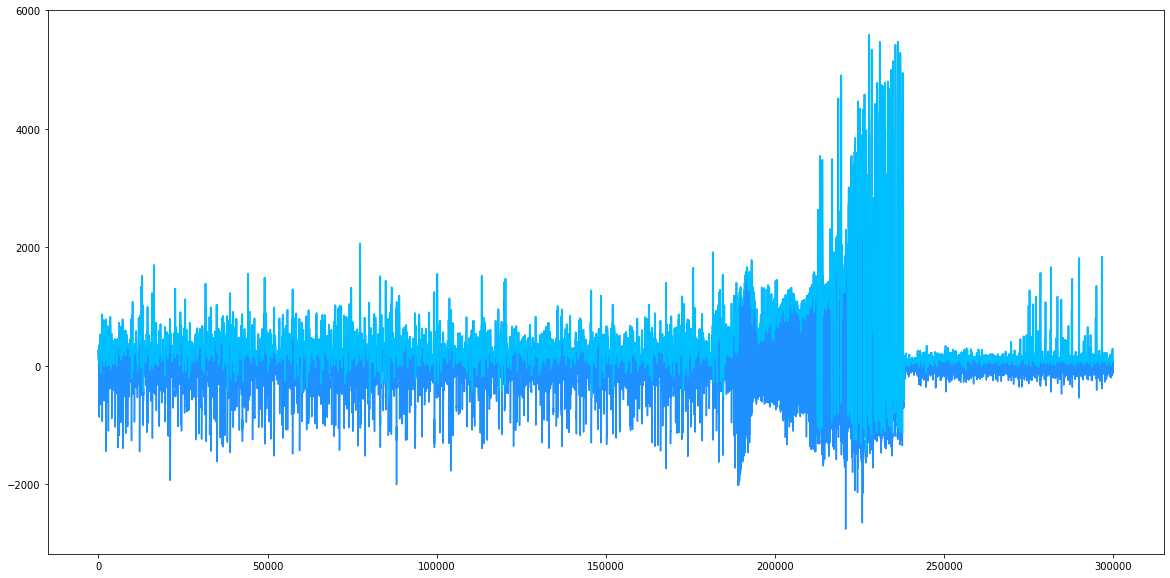

In [13]:
plot_feature(signal, scaled_max_feature, 0, 300000)

## Energy

$$
Energy = \sum_{x=x_0}^{x_0+N} y_x^2
$$


In [14]:
def calculate_energy(signal):
    return np.sum(np.power(signal,2))

In [15]:
energy_feature = calculate_feature(eegs, window_size, step_size, calculate_energy, max_power_eeg)
energy_feature_example = energy_feature[0][1]
scaled_energy_feature = scale_signal(energy_feature_example, window_size, step_size)

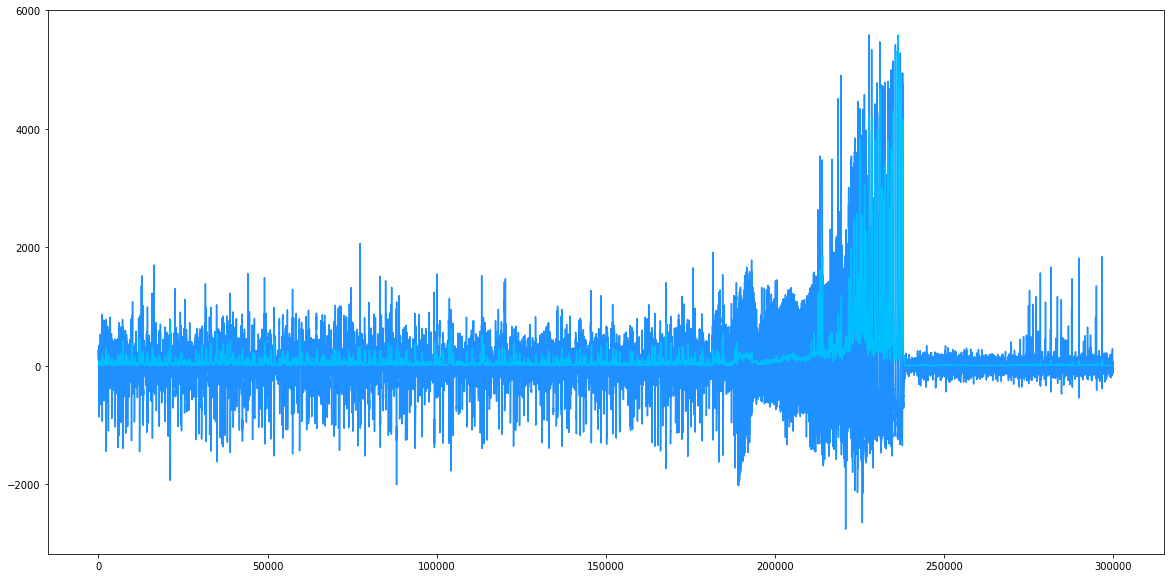

In [16]:
plot_feature(signal, scaled_energy_feature, 0, 300000)

## Line Length
$$
LineLength = \sum_{x=x_0+1}^{x_0+N}|y_x - y_{x-1}|
$$

In [17]:
def calculate_line_length(signal):
    offset_signal = signal[1:].copy()
    return(np.sum(np.abs(offset_signal-signal[:-1])))

In [18]:
line_length_feature = calculate_feature(eegs, window_size, step_size, calculate_line_length, max_power_eeg)
line_length_feature_example = line_length_feature[0][1]
scaled_line_length_feature = scale_signal(line_length_feature_example, window_size, step_size)

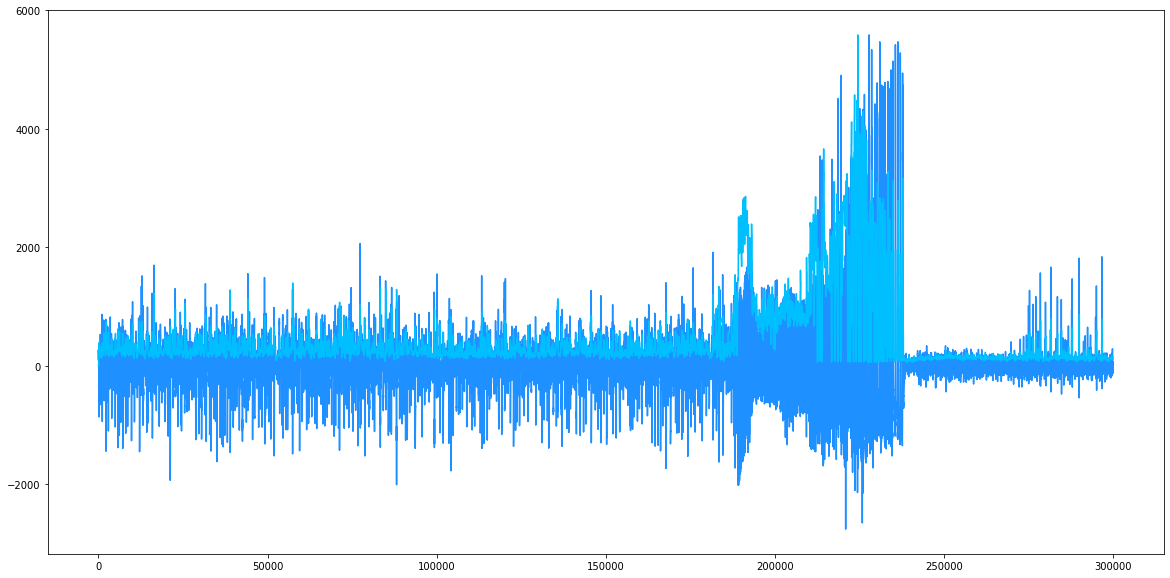

In [19]:
plot_feature(signal, scaled_line_length_feature, 0, 300000)

## Moving average

$$
MovingAverage = \frac{1}{N}\sum_{x=x_0}^{x_0+N}y_x
$$


In [20]:
def calculate_moving_avg(signal):
    return np.mean(signal)

In [21]:
moving_avg_feature = calculate_feature(eegs, window_size, step_size, calculate_moving_avg, max_power_eeg)
moving_avg_feature_example = moving_avg_feature[0][1]
scaled_moving_avg_feature = scale_signal(moving_avg_feature_example, window_size, step_size)

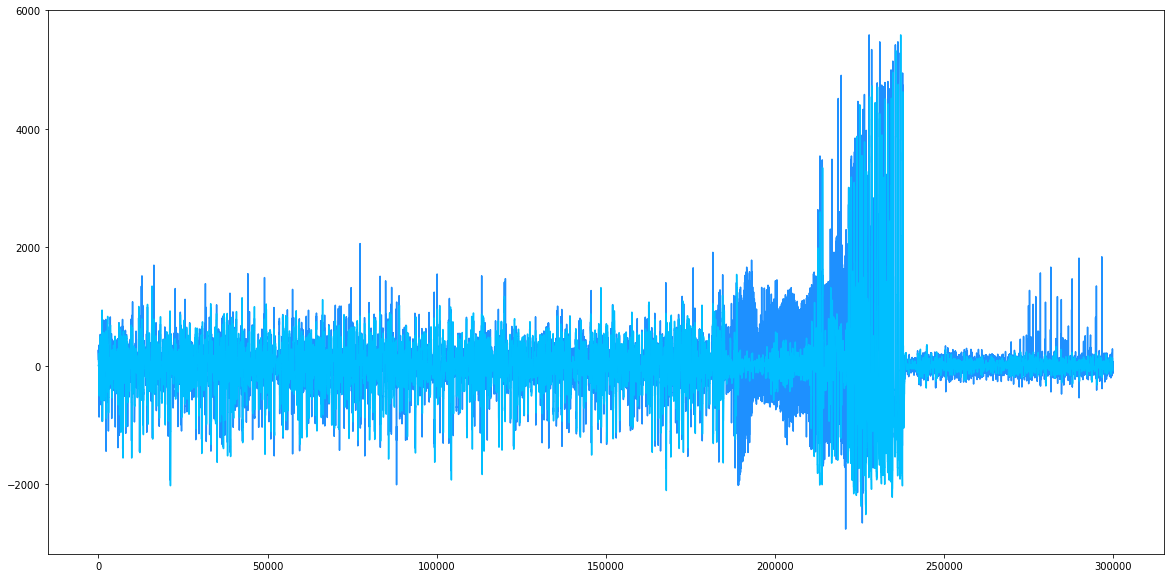

In [22]:
plot_feature(signal, scaled_moving_avg_feature, 0, 300000)

## Standard deviation
$$
StandardDeviation = \frac{1}{N}\sum_{x=x_0}^{x_0+N}(y_x-\mu)^2
$$


In [23]:
def calculate_std(signal):
    return np.std(signal)

In [24]:
std_feature = calculate_feature(eegs, window_size, step_size, calculate_std, max_power_eeg)
std_feature_example = std_feature[0][1]
scaled_std_feature = scale_signal(std_feature_example, window_size, step_size)

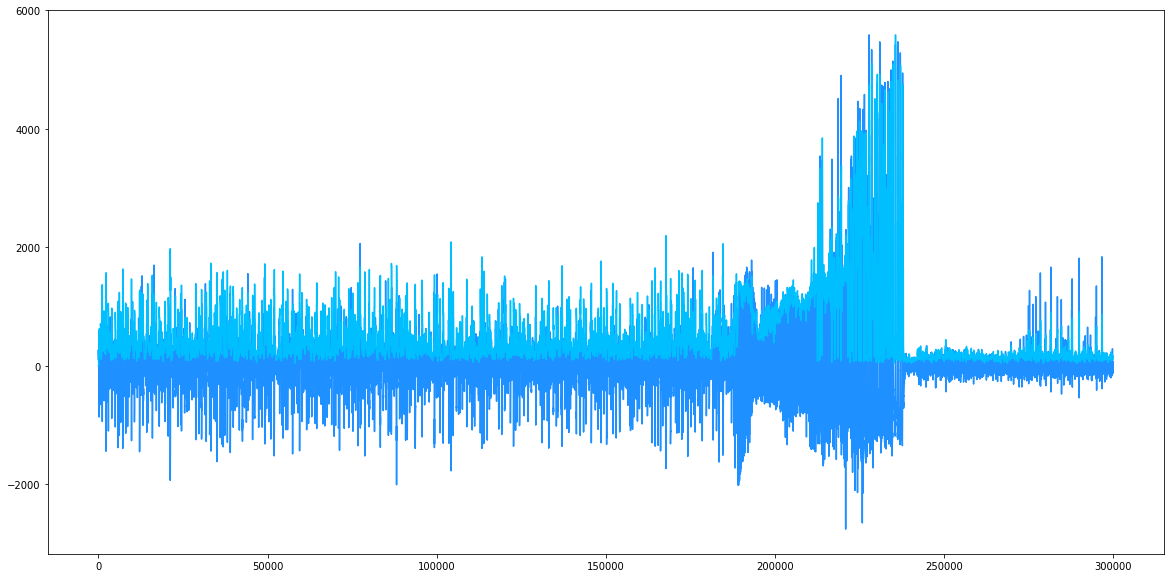

In [25]:
plot_feature(signal, scaled_std_feature, 0, 300000)

## Skewness

$$Skewness = \frac{\sqrt{N(N-1)}}{N(N-2)} g$$
$g = \frac{\sum_{x=x_0}^{x_0+N} (y_x - \mu)^3}{\sigma^3}$

In [26]:
def calculate_skewness(signal):
    std = np.std(signal)
    mean = np.mean(signal)
    n = len(signal)
    coeff = (n*(n-1))**0.5/(n*(n-2))
    skewness = np.sum(np.power(signal-mean,3))/std**3
    
    return coeff * skewness

In [27]:
skewness_feature = calculate_feature(eegs, window_size, step_size, calculate_skewness, max_power_eeg)
skewness_feature_example = skewness_feature[0][1]
scaled_skewness_feature = scale_signal(skewness_feature_example, window_size, step_size)

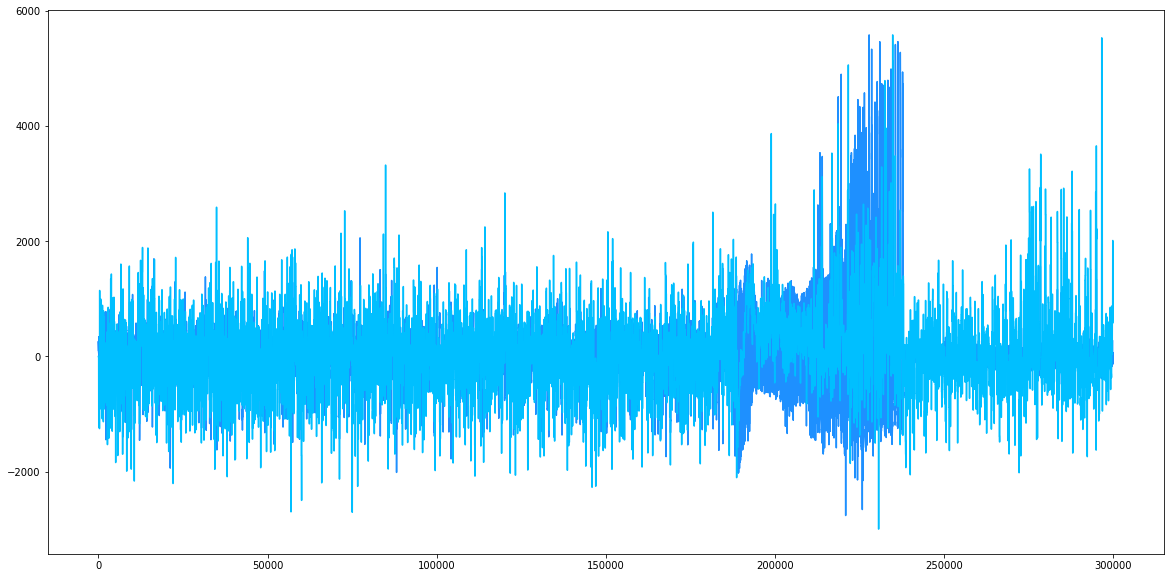

In [28]:
plot_feature(signal, scaled_skewness_feature, 0, 300000)

## Kurtosis

$$Kurtosis = \frac{N(N+1)}{(N-1)(N-2)(N-3)} g - \frac{(N-1)^2}{(N-2)(N-3)} 3$$

$g = \frac{\sum_{x=x_0}^{x_0+N} (y_x - \mu)^4}{\sigma^2}$

In [29]:
def calculate_kurtosis(signal):
    std = np.std(signal)
    mean = np.mean(signal)
    n = len(signal)
    coeff1 = (n*(n+1))/((n-1)*(n-2)*(n-3))
    coeff2 = (n-1)**2/((n-2)*(n-3))
    kurtosis = np.sum(np.power(signal-mean,4))/std**2
    return coeff1*kurtosis - coeff2*3

In [30]:
kurtosis_feature = calculate_feature(eegs, window_size, step_size, calculate_kurtosis, max_power_eeg)
kurtosis_feature_example = kurtosis_feature[0][1]
scaled_kurtosis_feature = scale_signal(kurtosis_feature_example, window_size, step_size)

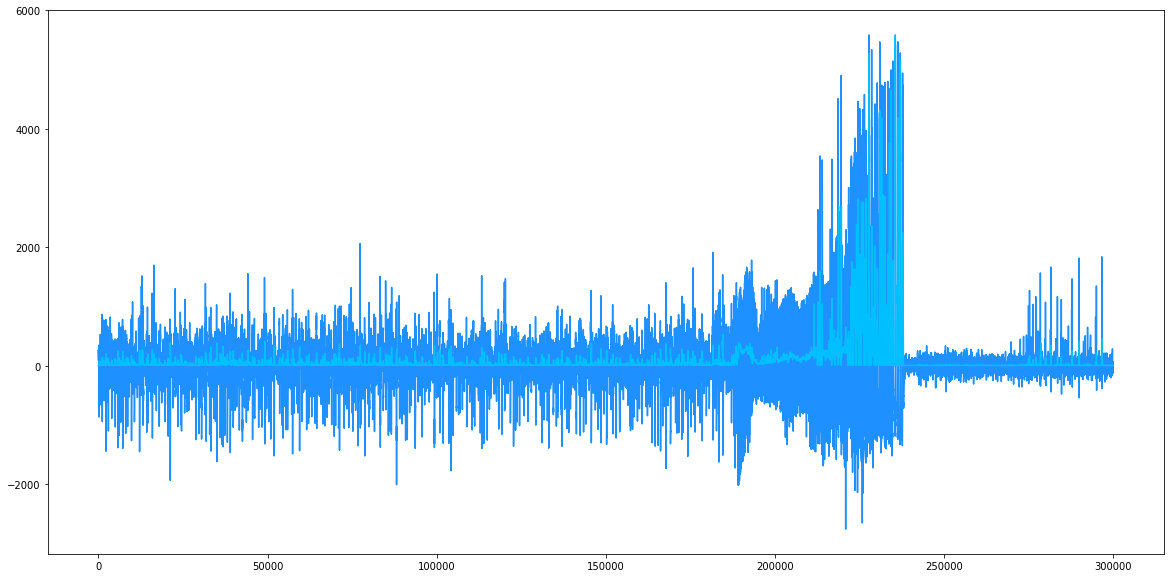

In [31]:
plot_feature(signal, scaled_kurtosis_feature, 0, 300000)

## Shannon entropy

$$ShannonEntropy = - \sum_{x=x_0}^{x_0+N} \text{freq}(y_x) \text{log}(\text{freq}(y_x))  $$

In [32]:
def calculate_shannon_entropy(signal, base=None):
    unique, counts = np.unique(signal, return_counts=True)
    n = len(signal)
    frequencies = counts/n
    return -np.sum(frequencies*np.log(frequencies))

In [33]:
shannon_entropy_feature = calculate_feature(eegs, window_size, step_size, calculate_shannon_entropy, max_power_eeg)
shannon_entropy_feature_example = shannon_entropy_feature[0][1]
scaled_shannon_entropy_feature = scale_signal(shannon_entropy_feature_example, window_size, step_size)

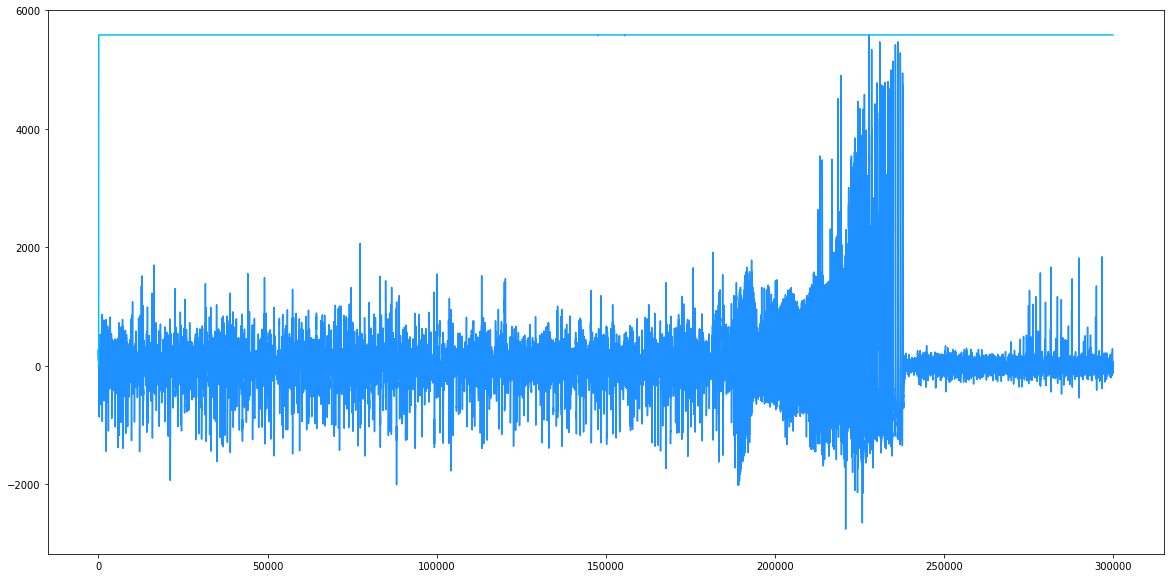

In [34]:
plot_feature(signal, scaled_shannon_entropy_feature, 0, 300000)

## Local Binary Patterns

$$\sum_{r=0}^{p/2^{-1}}\left\{S[x[i+r-P/_{2}]-x[i]]2^{r}+S[x[i+r+1]-x[i]]2^{r+P/2}\right\} \tag{1}$$

Taken from: [Local binary patterns for 1-D signal processing](https://ieeexplore.ieee.org/document/7096717)

*Remark: We should better perform an histogram of the values that we get within a window (see wikipedia)*

In [35]:
lbp_feature = calculate_feature(eegs, 1024, 512, calculate_lbp, min_power_eeg, max_power_eeg)
lbp_feature_example = lbp_feature[0][1]
scaled_lbp_feature = scale_signal(lbp_feature_example, 1024, 512)

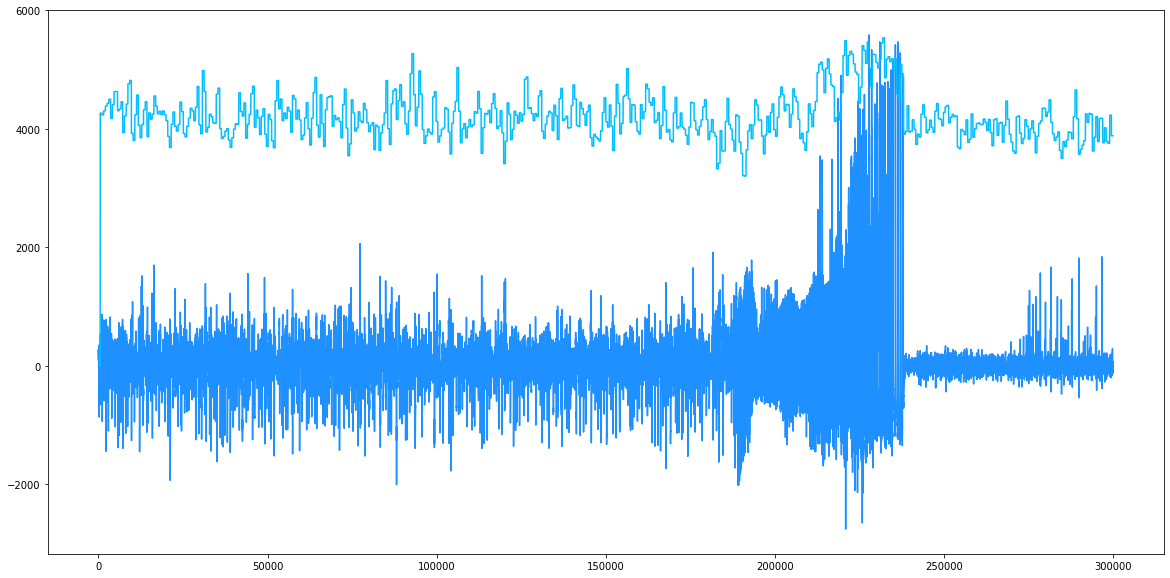

In [36]:
plot_feature(signal, scaled_lbp_feature, 0, 300000)

### Phase synchrony

$$PLV={1\over N}\sqrt{\left(\sum_{i=0}^{N-1}sin(\Delta \phi_{i})\right)^{2}+\left(\sum_{i=0}^{N-1}cos(\Delta \phi_{i})\right)^{2}}$$

Taken from : 
- [Phase-Synchronization Early Epileptic Seizure Detector](https://ieeexplore.ieee.org/document/6046232)
- [Rail-to-Rail-Input Dual-Radio 64-Channel
Closed-Loop Neurostimulator](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8068946)

Neurons initiate electrical oscillations that are contained in multiple frequency bands such as alpha (8–12 Hz), beta (13–30 Hz) and gamma (40–80 Hz) and have been linked to a wide range of cognitive and perceptual processes. It has been shown that before and during a seizure the amount of synchrony between these oscillations from neurons located in different regions of the brain changes significantly. Thus, the amount of synchrony between multiple neural signals is a strong indicator in predicting or detecting seizures. To quantify the level of synchrony between two neural signals, a phase locking value (PLV) can be computed that accurately measures the phase-synchronization between two signal sites in the brain.

In [37]:
def calculate_phase_synchrony(y1,y2):
    sig1_hill=sig.hilbert(y1)
    sig2_hill=sig.hilbert(y2)
    phase_y1=np.unwrap(np.angle(sig1_hill))
    phase_y2=np.unwrap(np.angle(sig2_hill))
    inst_phase_diff=phase_y1-phase_y2
    n = len(inst_phase_diff)
    
    sin_sum = np.sum(np.sin(inst_phase_diff))
    cos_sum = np.sum(np.cos(inst_phase_diff))
    
    return (1/n)*np.sqrt(np.power(sin_sum,2) + np.power(cos_sum,2))

In [38]:
phase_synchrony_feature = calculate_feature(eegs, window_size, step_size, calculate_phase_synchrony, max_power_eeg, min_power_eeg)
phase_synchrony_feature_example = phase_synchrony_feature[0][1]
scaled_phase_synchrony_feature = scale_signal(phase_synchrony_feature_example, window_size, step_size)

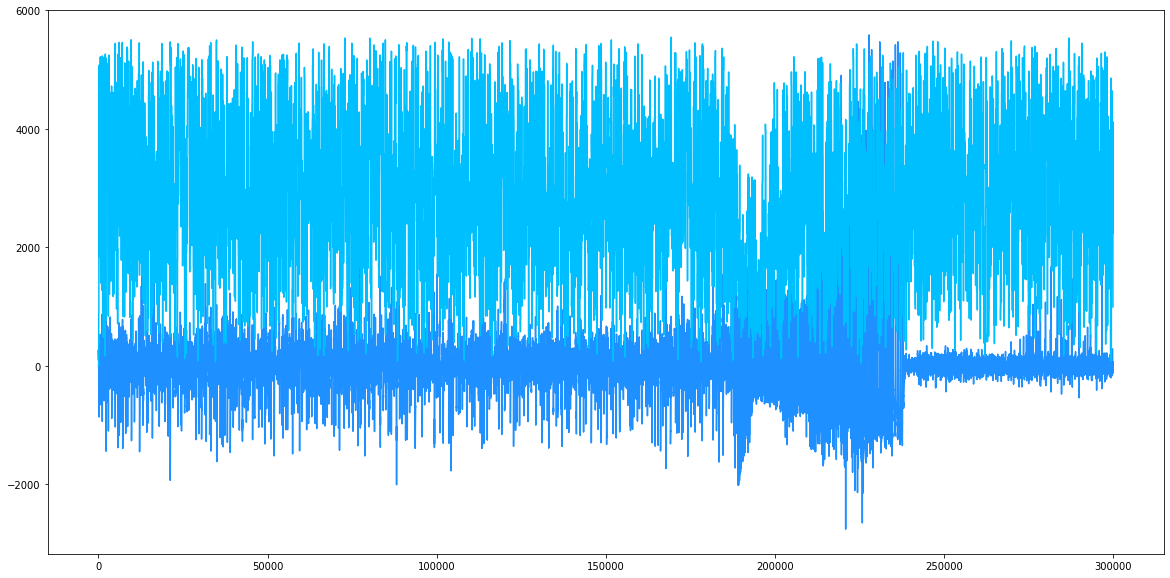

In [39]:
plot_feature(signal, scaled_phase_synchrony_feature, 0, 300000)

### Phase synchrony feature processing

In [40]:
inv_scaled_phase_synchrony_feature = 1/(np.array(scaled_phase_synchrony_feature)+1)
processed_phase_synchrony_feature = calculate_feature([[inv_scaled_phase_synchrony_feature]], window_size*16, step_size*16, calculate_min)
scaled_processed_phase_synchrony_feature= scale_signal(processed_phase_synchrony_feature[0][0], window_size*16, step_size*16)

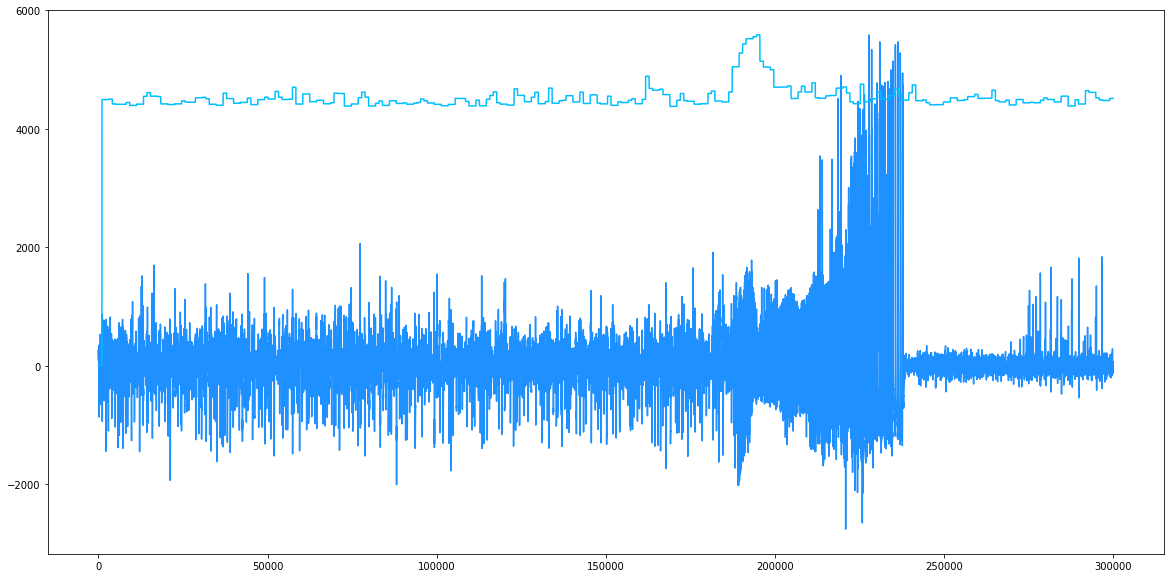

In [41]:
plot_feature(signal, scaled_processed_phase_synchrony_feature, 0, 300000)